<a href="https://www.kaggle.com/code/stargazer0115/onboarding-accelerate?scriptVersionId=284615316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚀 Onboard Accelerate
### An Agentic AI System for Assisting Software Engineer Onboarding

## 📌 Problem Statement

Many new software engineers enter corporate teams with limited knowledge to real-world workflows, codebase structures or company policies and practices. This lack of practical experience creates a significant skills gap during onboarding. Because most organizations lack scalable, standardized tools to support consistent training, employee remains confused for longer time, communication gaps widen, senior engineers spend excessive time providing ad-hoc guidance, and onboarding costs and timelines increase as teams grow.

## 🎯 Objective

To develop **Onboard Accelerate**, an **agentic AI system** that:

* Creates clear, role-specific onboarding plans using company documentation, codebases, and industry best practices—making it easier for trainers to design effective and consistent training programs.

* Reduces knowledge gaps by generating easy-to-follow learning materials such as schedules, tasks, code walkthroughs, and quizzes that help new engineers understand concepts more quickly.

* Serves as a support platform where new engineers can ask questions and receive instant, AI-driven answers, enabling faster learning, greater confidence, and smoother integration into their teams.

## 📚 Background

* The article “Strategic Onboarding: How to Set Up New Hires for Long-Term Success” states that onboarding must launch new hires to long-term success by building confidence and accelerating contribution—not just completing setup tasks (Walch, 2025).
  
* Programs like CodePath highlight the growing need for structured, practical training that prepares engineers for real-world work, yet most companies still lack a consistent and well-defined onboarding process once engineers are hired.

* This project is directly inspired by the "Noogler" experience at Google and the institutional recognition that new hires require a dedicated, effective system to quickly transition from theoretical knowledge to corporate contribution.

Creating effective onboarding plans is resource-intensive, and without the right tools, organizations struggle to scale and maintain them over time. By leveraging Google’s agentic AI capabilities, companies can streamline onboarding plan development and provide real-time guidance to new engineers, enabling faster learning, improved clarity, and a more confident start in their roles.

## 📌 Project Scope
- **Role-specific onboarding plan generation** using company documents, codebases, and industry best practices.
- **AI-generated learning materials** such as onboarding schedules, assignments, code walkthroughs, and quizzes to support skill development.
- **Question–answer support** where new engineers can ask onboarding-related questions and receive AI-driven responses.
- **Use of external data sources** (e.g., Google APIs) to benchmark onboarding content against current industry standards.
- **Agentic workflow orchestration** allowing the AI to reason, retrieve information, and refine onboarding outputs as needed.

- Multi-agent pipeline (sequential): Role & Context → Planner → Content → Q&A.  
- Sessions & memory to track each engineer’s onboarding journey.  
- CLI-style evaluation to score the quality of generated onboarding plans (no ADK).


## 🧩 Workflow Breakdown

* User provides **Role & Team Context**, which is processed by the **Role & Context Agent** to extract a structured role profile.

* The **Onboarding Planner Agent** converts the role profile into a phased onboarding plan with goals and milestones.

* The **Content & Materials Agent** expands the onboarding plan into detailed learning assets such as tasks, walkthroughs, readings, and quizzes.

* The **Q&A Support Agent** uses the onboarding plan and learning assets to answer follow-up questions.

* An async pipeline orchestrates every agent, ensures JSON-cleaning and validation, and stores all outputs in a session object.
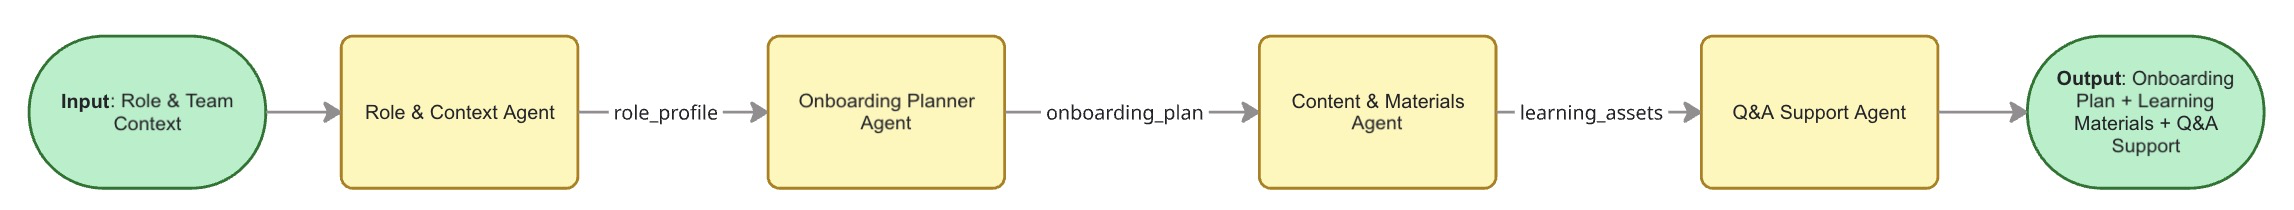
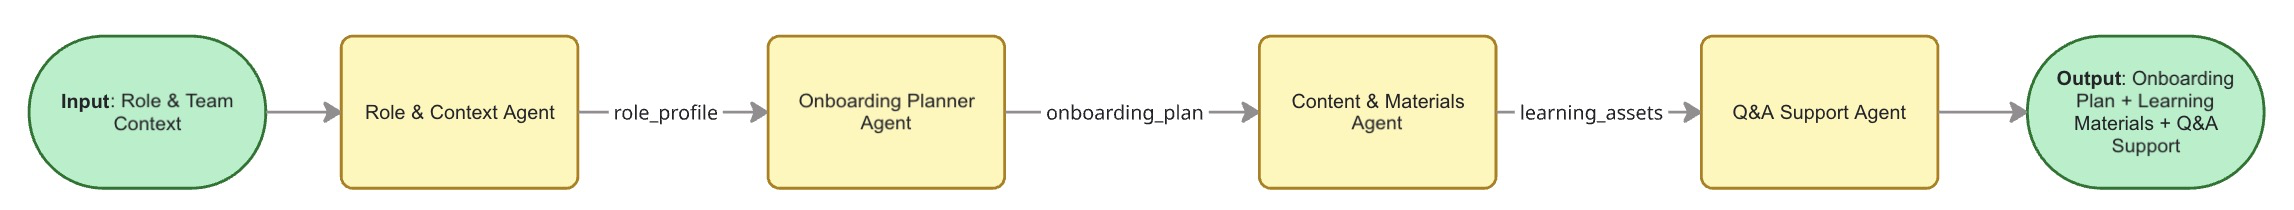

## 🔑 Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/), which requires an API key.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to access the `GOOGLE_API_KEY` you just saved and set it as an environment variable for the notebook to use:

In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


## 1) Applying Multi-Agent

In [2]:
from google.genai import types
from google.adk.agents import LlmAgent, SequentialAgent
from google.adk.models.google_llm import Gemini

MODEL_NAME = "gemini-2.5-flash-lite"

model = Gemini(
    model=MODEL_NAME,
    generate_content_config=types.GenerateContentConfig(
        temperature=0.3,
        max_output_tokens=2048,
    ),
)

# 1) Role & Context Agent ------------------------------------
role_context_agent = LlmAgent(
    model=model,
    name="role_context_agent",
    description="Collect and structure role + team context for onboarding.",
    instruction=(
        "You are an assistant that turns messy role and team info into a clean role profile "
        "for onboarding. Extract: role_title, team_name, tech_stack, key_systems and primary_responsibilities "
        "Respond in JSON."
    ),
)

# 2) Onboarding Planner Agent --------------------------------
planner_agent = LlmAgent(
    model=model,
    name="onboarding_planner_agent",
    description="Designs the structured onboarding plan for a software engineer.",
    instruction=(
        "You receive a role_profile in JSON.\n\n"
        "Produce a structured onboarding plan with the following EXACT JSON keys:\n"
        "  - overall_goals: a list of high-level onboarding goals.\n"
        "  - phases: a list of objects, each with:\n"
        "        {\"name\": str, \"duration_days\": int, \"activities\": [str]}\n"
        "  - measurable_outcomes: a list of outcomes by end of onboarding.\n\n"
        "Output ONLY valid JSON. Do NOT include milestones, weekly_goals, or duration_days "
        "unless they are part of the above three fields.\n"
    ),
    # tools=[search_tool],  # you can re-enable tools once you have the correct WebSearchTool
)

# 3) Content & Materials Agent -------------------------------
content_agent = LlmAgent(
    model=model,
    name="content_materials_agent",
    description="Generates tasks, walkthroughs, and quizzes from an onboarding plan.",
    instruction=(
        "You receive a JSON object with key `onboarding_plan`.\n\n"
        "Using the milestones, goals, and structure from that plan, generate DETAILED "
        "learning materials for a new engineer.\n\n"
        "Your output MUST be ONLY valid JSON with EXACTLY the following top-level keys:\n"
        "  - tasks: a list of strings\n"
        "  - codebase_walkthroughs: a list of strings\n"
        "  - reading_list: a list of strings (URLs or docs)\n"
        "  - quizzes: a list of {question: str, options: [str], answer: str}\n"
        "  - scenarios: a list of realistic on-the-job scenarios\n\n"
    ),
    # tools=[search_tool],
)

# 4) Q&A Support Agent ---------------------------------------
qa_support_agent = LlmAgent(
    model=model,
    name="qa_support_agent",
    description="Answers onboarding questions from new engineers.",
    instruction=(
        "You are an onboarding support assistant for new software engineers. "
        "Use the onboarding_plan + learning materials + search to answer "
        "questions clearly and concisely. If unsure, say so and suggest what "
        "they should ask their manager."
    ),
    # tools=[search_tool],
)

root_agent = SequentialAgent(
    name="onboarding_pipeline",
    sub_agents=[role_context_agent, planner_agent, content_agent]
)

## 2) Initialzing SESSION + MEMORY SYSTEM

In [3]:
# ============================
# 📓 SESSION + MEMORY SYSTEM
# ============================

import uuid
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional

# -----------------------------
# 📝 Event = entry in a session
# -----------------------------
@dataclass
class Event:
    role: str              # "user" | "assistant" | "agent"
    content: str
    metadata: Dict[str, Any] = field(default_factory=dict)


# ---------------------------------------
# 📓 Core data models
# ---------------------------------------
@dataclass
class RoleProfile:
    role_title: str
    team_name: str
    tech_stack: List[str]
    key_systems: List[str]
    primary_responsibilities: List[str]
    seniority_level: str = "junior"
    important_dependencies: List[str] = field(default_factory=list)


@dataclass
class OnboardingPlan:
    overall_goals: List[str]
    phases: List[Dict[str, Any]]
    measurable_outcomes: List[str]


@dataclass
class LearningAssets:
    tasks: List[str]
    codebase_walkthroughs: List[str]
    reading_list: List[str]
    quizzes: List[Dict[str, Any]]
    scenarios: List[str]


# ---------------------------------------
# 📓 OnboardingSession = your notebook
# ---------------------------------------
@dataclass
class OnboardingSession:
    """
    A notebook storing all outputs for a single onboarding journey.
    """
    session_id: str
    events: List[Event] = field(default_factory=list)
    role_profile: Optional[RoleProfile] = None
    onboarding_plan: Optional[OnboardingPlan] = None
    learning_assets: Optional[LearningAssets] = None
    summary: Optional[str] = None


# ------------------------------------------------
# 🗄️ Optional: JSON-backed SessionService
# ------------------------------------------------
import json

class SessionStore:
    """
    Stores and retrieves sessions. All sessions persist to sessions.json.
    (Very similar to the Kaggle notebook.)
    """
    def __init__(self, path: str = "sessions.json"):
        self.path = path
        self.sessions: Dict[str, OnboardingSession] = {}
        self._load()

    def _load(self):
        try:
            with open(self.path, "r", encoding="utf-8") as f:
                raw = json.load(f)
        except FileNotFoundError:
            self.sessions = {}
            return

        self.sessions = {
            sid: self._session_from_dict(data)
            for sid, data in raw.items()
        }

    def _save(self):
        data = {
            sid: self._session_to_dict(s)
            for sid, s in self.sessions.items()
        }
        with open(self.path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)

    def create_session(self) -> OnboardingSession:
        sid = str(uuid.uuid4())
        session = OnboardingSession(session_id=sid)
        self.sessions[sid] = session
        self._save()
        return session

    def save_session(self, session: OnboardingSession) -> None:
        self.sessions[session.session_id] = session
        self._save()

    def get_session(self, session_id: str) -> Optional[OnboardingSession]:
        return self.sessions.get(session_id)

    def _session_to_dict(self, session: OnboardingSession) -> Dict[str, Any]:
        return asdict(session)

    def _session_from_dict(self, data: Dict[str, Any]) -> OnboardingSession:
        events = [Event(**e) for e in data.get("events", [])]

        rp = data.get("role_profile")
        role_profile = RoleProfile(**rp) if rp else None

        op = data.get("onboarding_plan")
        onboarding_plan = (
            OnboardingPlan(
                overall_goals=op["overall_goals"],
                phases=op["phases"],
                measurable_outcomes=op["measurable_outcomes"],
            ) if op else None
        )

        la = data.get("learning_assets")
        learning_assets = (
            LearningAssets(
                tasks=la["tasks"],
                codebase_walkthroughs=la["codebase_walkthroughs"],
                reading_list=la["reading_list"],
                quizzes=la["quizzes"],
                scenarios=la["scenarios"],
            ) if la else None
        )

        return OnboardingSession(
            session_id=data["session_id"],
            events=events,
            role_profile=role_profile,
            onboarding_plan=onboarding_plan,
            learning_assets=learning_assets,
            summary=data.get("summary"),
        )


session_store = SessionStore()
print("✅ Data models + SessionStore loaded")


✅ Data models + SessionStore loaded


### Extra handling with session and helper function

In [4]:
import asyncio
from google.genai import types
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
import json
import re
from dataclasses import fields as dataclass_fields

adk_session_service = InMemorySessionService()

def parse_json_safely(text: str) -> dict:
    text = text.strip()
    if not text:
        raise ValueError("Model returned empty string instead of JSON.")

    # 1) Strip markdown code fences ```json ... ```
    if text.startswith("```"):
        # remove the opening ```... line
        text = re.sub(r"^```[a-zA-Z0-9]*\s*", "", text)
        # remove trailing ```
        if text.endswith("```"):
            text = text[:-3].strip()

    # 2) If there is extra explanation, grab the first {...} block
    start = text.find("{")
    end = text.rfind("}")
    if start != -1 and end != -1 and start < end:
        text = text[start : end + 1]

    # 3) Now parse JSON
    return json.loads(text)

def clean_json_for_dataclass(text: str, cls):
    text = text.strip()
    if not text:
        raise ValueError("Model returned empty string instead of JSON.")

    # Strip ```json fences
    if text.startswith("```"):
        text = re.sub(r"^```[a-zA-Z0-9]*\s*", "", text)
        if text.endswith("```"):
            text = text[:-3].strip()

    # Parse object or extract first {...}
    if text and text[0] in "{[":
        data = json.loads(text)
    else:
        start, end = text.find("{"), text.rfind("}")
        if start == -1 or end == -1 or start >= end:
            raise ValueError(f"Model did not return JSON. Got: {repr(text[:200])}")
        data = json.loads(text[start:end+1])

    # If wrapped under a single key (e.g., {"onboarding_plan": {...}}), unwrap it
    if isinstance(data, dict):
        allowed = {f.name for f in dataclass_fields(cls)}
        if not any(k in allowed for k in data.keys()) and len(data) == 1:
            only_val = next(iter(data.values()))
            if isinstance(only_val, dict):
                data = only_val

        # Keep only dataclass fields
        data = {k: v for k, v in data.items() if k in allowed}

    return data


async def call_single_agent(agent, user_text: str) -> str:
    """
    Minimal Kaggle-style helper:
    - Creates an ADK session for the agent
    - Runs the agent once
    - Returns the final text output
    """
    adk_session = await adk_session_service.create_session(
        app_name="default",
        user_id="local-user",
        session_id=str(uuid.uuid4()),
    )

    runner = Runner(
        agent=agent,
        session_service=adk_session_service,
        app_name="default",
    )

    content = types.Content(
        role="user",
        parts=[types.Part(text=user_text)],
    )

    final_text = ""

    async for event in runner.run_async(
        user_id="local-user",
        session_id=adk_session.id,
        new_message=content,
    ):
        if event.is_final_response() and event.content and event.content.parts:
            final_text = event.content.parts[0].text
    return final_text


async def run_onboarding_pipeline_async(user_role_input: str) -> OnboardingSession:
    """
    Kaggle-style orchestration:
      1) Create an app-level OnboardingSession (your notebook)
      2) Call 3 agents in sequence via ADK
      3) Fill RoleProfile, OnboardingPlan, LearningAssets
      4) Save to session_store (optional)
    """
    # 0️⃣ Create your own notebook session
    session = session_store.create_session()
    session.events.append(Event(role="user", content=user_role_input))

    # 1️⃣ Role & Context Agent
    raw_role_profile = await call_single_agent(role_context_agent, user_role_input)
    role_profile_json = clean_json_for_dataclass(raw_role_profile, RoleProfile)
    session.role_profile = RoleProfile(**role_profile_json)

    # 2️⃣ Planner Agent
    planner_input = json.dumps(role_profile_json)
    raw_plan = await call_single_agent(planner_agent, planner_input)
    onboarding_plan_json = clean_json_for_dataclass(raw_plan, OnboardingPlan)
    session.onboarding_plan = OnboardingPlan(**onboarding_plan_json)

    # 3️⃣ Content Agent
    content_input = json.dumps({"onboarding_plan": onboarding_plan_json})
    raw_assets = await call_single_agent(content_agent, content_input)
    learning_assets_json = clean_json_for_dataclass(raw_assets, LearningAssets)
    session.learning_assets = LearningAssets(**learning_assets_json)
    session.events.append(Event(role="agent", content="learning_assets", metadata=learning_assets_json))

    # Optional summary
    if len(session.events) > 10:
        session.summary = "Generated role profile, onboarding plan, and learning assets."

    # Save to disk (Kaggle-style)
    session_store.save_session(session)

    return session
    

## 4) Testing 

In [5]:
from pprint import pprint
demo_role_input = (
    "Backend SWE on the Payments team using Java, Spring Boot, and PostgreSQL. "
    "Generate a 2-week onboarding plan."
)

# In a notebook, you must use `await`:
session = await run_onboarding_pipeline_async(demo_role_input)

print("\n==== ROLE PROFILE ====")
pprint(session.role_profile)

print("\n==== ONBOARDING PLAN ====")
pprint(session.onboarding_plan)

print("\n==== LEARNING ASSETS ====")
pprint(session.learning_assets)


==== ROLE PROFILE ====
RoleProfile(role_title='Backend Software Engineer',
            team_name='Payments',
            tech_stack=['Java', 'Spring Boot', 'PostgreSQL'],
            key_systems=['Payment Processing System', 'Transaction Database'],
            primary_responsibilities=['Develop and maintain backend services '
                                      'for payment processing.',
                                      'Design and implement database schemas '
                                      'and queries.',
                                      'Collaborate with frontend engineers and '
                                      'product managers.',
                                      'Ensure the reliability, scalability, '
                                      'and security of payment systems.'],
            seniority_level='junior',
            important_dependencies=[])

==== ONBOARDING PLAN ====
OnboardingPlan(overall_goals=['Become a productive and integrated member of

## 5) Onboarding Questions Agent

In [6]:
import json

def answer_onboarding_question(session: OnboardingSession, question: str) -> str:
    # Build context_blob from plan + assets
    context_blob = json.dumps(
        {
            "role_profile": session.role_profile.__dict__ if session.role_profile else {},
            "onboarding_plan": {
                "overall_goals": session.onboarding_plan.overall_goals,
                "phases": session.onboarding_plan.phases,
                "measurable_outcomes": session.onboarding_plan.measurable_outcomes,
            } if session.onboarding_plan else {},
            "learning_assets": {
                "tasks": session.learning_assets.tasks,
                "codebase_walkthroughs": session.learning_assets.codebase_walkthroughs,
                "reading_list": session.learning_assets.reading_list,
                "quizzes": session.learning_assets.quizzes,
                "scenarios": session.learning_assets.scenarios,
            } if session.learning_assets else {},
        },
        indent=2
    )

    prompt = f"""
    You are an onboarding assistant helping a new engineer ramp up.

    Use the context below to answer their question in a practical, concise way.
    If some info is missing from the context, say what assumptions you're making.

    Context:
    {context_blob}

    Question from new engineer:
    {question}
    """

    raw = qa_support_agent.run(prompt)
    answer = raw if isinstance(raw, str) else str(raw)

    session.events.append(Event(role="user", content=question))
    session.events.append(Event(role="assistant", content=answer))
    session_service.save_session(session)

    return answer


In [7]:
def start_onboarding_cli(session):
    print("Onboarding CLI is ready!")
    print("Type any question about your role or onboarding.")
    print("Type 'exit' or 'quit' to stop.\n")

    while True:
        try:
            question = input("You: ").strip()
        except (EOFError, KeyboardInterrupt):
            print("\nExiting.")
            break

        if question.lower() in {"exit", "quit"}:
            print("Goodbye!")
            break
        
        if not question:
            continue

        answer = answer_onboarding_question(session, question)
        print("\nAssistant:\n")
        print(answer)
        print("\n---\n")

demo_role_input = {
    "role_title": "Software Engineer, Data Platform",
    "team_name": "Data Infrastructure",
    "tech_stack": ["Python", "BigQuery", "GCP"],
    "manager_notes": "Focus on pipeline reliability."
}


#### Start CLI with this 

```
start_onboarding_cli(session)
```

## 📚 References
* [ADK Documentation](https://google.github.io/adk-docs/)
- [ADK Tools Documentation](https://google.github.io/adk-docs/tools/)
* [Google.org supports CodePath to train 25,000 AI-native software engineers.](http://www.prnewswire.com/news-releases/googleorg-supports-codepath-to-train-25-000-ai-native-software-engineers-in-the-next-two-years-302251683.html?utm_source=chatgpt.com)
* Brian Walch, “Strategic Onboarding: How to set up new hires for long-term success,” Alaska Business Monthly, Sept 17 2025.